## Requirements

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


## Imports

In [2]:
from collections import Counter

import joblib
import numpy as np
import torch
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch import nn
from tqdm import tqdm

from models import rf_model, xgb_model, MLPClassifier, AutoencoderClassifier

In [3]:
from datasets import TestDataset, AcousticDataset
from utility_functions import find_knn_per_class, apply_smote, normalize_and_shuffle, balance_test_set, \
    prepare_dataloaders, print_class_distribution, plot_roc_curves, plot_training_curves

## Data loading and preprocessing

In [4]:
dataset = TestDataset("data_files/new click trains (Bulgaria)")
test_x, test_y, test_meta = dataset.get_labeled()

print(f"Test samples: {len(test_x)}")

train_dataset = AcousticDataset(
    "data_files/Train_details/B Balchik 2020 11 14 FPOD_6288 file0 PART 79d 23h 19m train details",
    "data_files/datasets/CLICK TRAINS.xlsx")

labeled_x, labeled_y, labeled_meta = train_dataset.get_labeled()
unlabeled_x, unlabeled_meta = train_dataset.get_unlabeled()

Test samples: 64


## Upsampling

In [5]:
# ===================================
# Step 1: Upsample Each Class via KNN
# ===================================

n_to_add_per_class = 3000  # Target number of samples per class after upsampling

all_new_x = []  # To store pseudo-labeled features for each class
all_new_y = []  # To store pseudo-labels for each class

# Iterate over each unique class in the labeled dataset
for cls in np.unique(labeled_y):
    # Calculate how many new samples are needed for this class
    current_class_count = np.sum(labeled_y == cls)
    n_to_add = n_to_add_per_class - current_class_count

    # Skip if no samples need to be added
    if n_to_add <= 0:
        print(f"Class {cls}: no samples to add (already has {current_class_count}).")
        continue

    # Apply KNN to find similar samples from the unlabeled pool
    results, new_x, new_y, unlabeled_x, unlabeled_meta = find_knn_per_class(
        labeled_x, labeled_y,
        unlabeled_x, unlabeled_meta,
        target_class=cls,
        n_to_add=n_to_add,
        distance_threshold=2000  # Distance threshold for selecting neighbors
    )

    print(f"Class {cls}: added {len(new_y)} new samples.")

    all_new_x.append(new_x)
    all_new_y.append(new_y)

# Stack pseudo-labeled samples
pseudo_x = np.vstack(all_new_x)
pseudo_y = np.concatenate(all_new_y)

print("Final upsampled pseudo-labeled set size:", pseudo_x.shape)
print("Remaining unlabeled sample count:", unlabeled_x.shape)

# ===================================
# Step 2: Combine Labeled and Pseudo-Labeled Data
# ===================================

X_combined = np.concatenate([labeled_x, pseudo_x])
y_combined = np.concatenate([labeled_y, pseudo_y])

print("Class distribution before SMOTE:", Counter(y_combined))

# ===================================
# Step 3: Apply SMOTE for Final Balancing
# ===================================

X_resampled, y_resampled = apply_smote(X_combined, y_combined)

print("Class distribution after SMOTE:", Counter(y_resampled))


Class 0: added 2471 new samples.
Class 1: added 2672 new samples.
Final upsampled pseudo-labeled set size: (5143, 24)
Remaining unlabeled sample count: (13139340, 24)
Class distribution before SMOTE: Counter({np.int64(1): 3000, np.int64(0): 2644})
Original class distribution: Counter({np.int64(1): 3000, np.int64(0): 2644})
Resampled class distribution: Counter({np.int64(0): 3000, np.int64(1): 3000})
Class distribution after SMOTE: Counter({np.int64(0): 3000, np.int64(1): 3000})


## Data preprocessing

In [6]:
# Normalize and shuffle
X_all, y_all, scaler = normalize_and_shuffle(X_resampled, y_resampled)
test_x = scaler.transform(test_x)
joblib.dump(scaler, "./save/scaler.pkl")
# Split
train_x, val_x, train_y, val_y = train_test_split(X_all, y_all, test_size=0.3, random_state=42)

# Balance test set
test_x, test_y, test_meta = balance_test_set(test_x, test_y, test_meta)
# Print distributions
print_class_distribution("Train", train_y)
print_class_distribution("Validation", val_y)
print_class_distribution("Test", test_y)


Train Distribution:
  Class 0: 2117 (50.40%)
  Class 1: 2083 (49.60%)

Validation Distribution:
  Class 1: 917 (50.94%)
  Class 0: 883 (49.06%)

Test Distribution:
  Class 1: 22 (50.00%)
  Class 0: 22 (50.00%)


# Models training

## Random Forest

Evaluation:
Accuracy: 0.8864
F1 Score (macro): 0.8863
F1 Score (weighted): 0.8863

Per-Class Classification Report:
              precision    recall  f1-score   support

           0     0.8696    0.9091    0.8889        22
           1     0.9048    0.8636    0.8837        22

    accuracy                         0.8864        44
   macro avg     0.8872    0.8864    0.8863        44
weighted avg     0.8872    0.8864    0.8863        44

Confusion Matrix:
[[20  2]
 [ 3 19]]


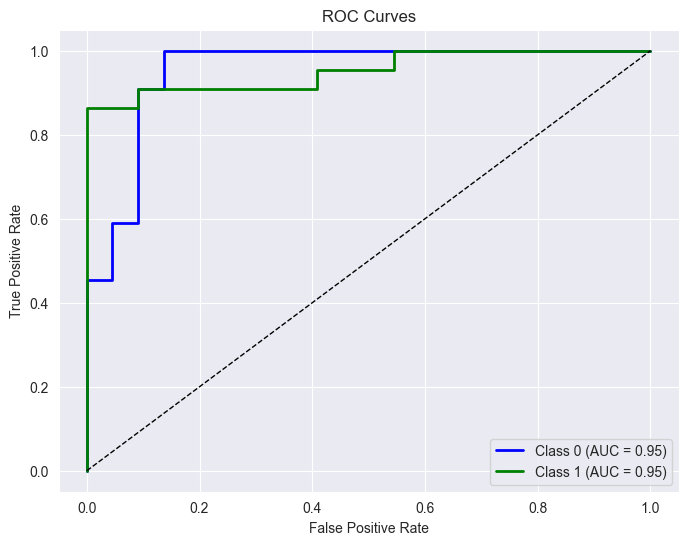

In [7]:
rf_model.fit(train_x, train_y)

probs = rf_model.predict_proba(test_x)
preds = rf_model.predict(test_x)

print("Evaluation:")
print(f"Accuracy: {accuracy_score(test_y, preds):.4f}")
print(f"F1 Score (macro): {f1_score(test_y, preds, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(test_y, preds, average='weighted'):.4f}")
print("\nPer-Class Classification Report:")
print(classification_report(test_y, preds, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(test_y, preds))
plot_roc_curves(test_y, probs)

## XGBoost

Evaluation:
Accuracy: 0.8864
F1 Score (macro): 0.8863
F1 Score (weighted): 0.8863

Per-Class Classification Report:
              precision    recall  f1-score   support

           0     0.8696    0.9091    0.8889        22
           1     0.9048    0.8636    0.8837        22

    accuracy                         0.8864        44
   macro avg     0.8872    0.8864    0.8863        44
weighted avg     0.8872    0.8864    0.8863        44

Confusion Matrix:
[[20  2]
 [ 3 19]]


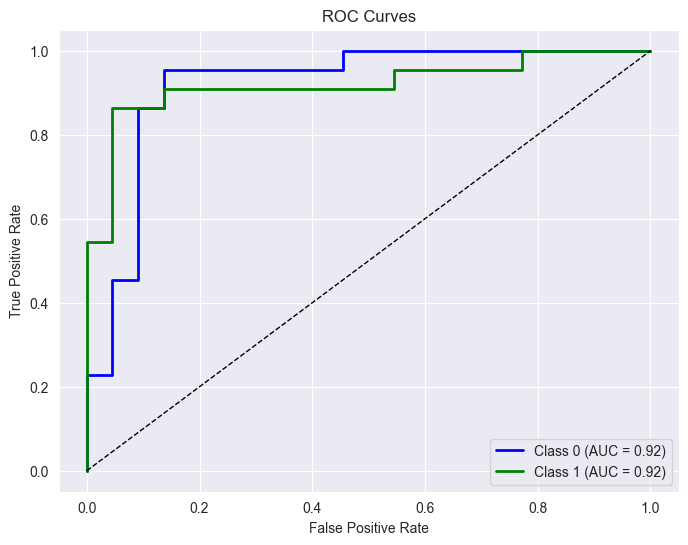

In [8]:
xgb_model.fit(train_x, train_y)

probs = xgb_model.predict_proba(test_x)
preds = xgb_model.predict(test_x)

print("Evaluation:")
print(f"Accuracy: {accuracy_score(test_y, preds):.4f}")
print(f"F1 Score (macro): {f1_score(test_y, preds, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(test_y, preds, average='weighted'):.4f}")
print("\nPer-Class Classification Report:")
print(classification_report(test_y, preds, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(test_y, preds))
plot_roc_curves(test_y, probs)

## MLP


Epoch 1 Summary:
Train Loss: 0.4466, Train Acc: 0.8014
Val Loss: 0.2971, Val Acc: 0.8900, Val F1: 0.8898



Epoch 2 Summary:
Train Loss: 0.2522, Train Acc: 0.9145
Val Loss: 0.2290, Val Acc: 0.9239, Val F1: 0.9237



Epoch 3 Summary:
Train Loss: 0.2107, Train Acc: 0.9295
Val Loss: 0.1922, Val Acc: 0.9328, Val F1: 0.9326



Epoch 4 Summary:
Train Loss: 0.1855, Train Acc: 0.9395
Val Loss: 0.1738, Val Acc: 0.9389, Val F1: 0.9388



Epoch 5 Summary:
Train Loss: 0.1709, Train Acc: 0.9414
Val Loss: 0.1646, Val Acc: 0.9417, Val F1: 0.9415



Epoch 6 Summary:
Train Loss: 0.1690, Train Acc: 0.9424
Val Loss: 0.1587, Val Acc: 0.9439, Val F1: 0.9438



Epoch 7 Summary:
Train Loss: 0.1615, Train Acc: 0.9445
Val Loss: 0.1543, Val Acc: 0.9467, Val F1: 0.9466



Epoch 8 Summary:
Train Loss: 0.1525, Train Acc: 0.9476
Val Loss: 0.1539, Val Acc: 0.9461, Val F1: 0.9460



Epoch 9 Summary:
Train Loss: 0.1539, Train Acc: 0.9469
Val Loss: 0.1491, Val Acc: 0.9517, Val F1: 0.9516



Epoch 10 Summary:
Train Loss: 0.1532, Train Acc: 0.9498
Val Loss: 0.1490, Val Acc: 0.9494, Val F1: 0.9494



Epoch 11 Summary:
Train Loss: 0.1462, Train Acc: 0.9443
Val Loss: 0.1495, Val Acc: 0.9467, Val F1: 0.9466



Epoch 12 Summary:
Train Loss: 0.1458, Train Acc: 0.9517
Val Loss: 0.1472, Val Acc: 0.9478, Val F1: 0.9477



Epoch 13 Summary:
Train Loss: 0.1446, Train Acc: 0.9486
Val Loss: 0.1420, Val Acc: 0.9500, Val F1: 0.9500



Epoch 14 Summary:
Train Loss: 0.1397, Train Acc: 0.9505
Val Loss: 0.1420, Val Acc: 0.9517, Val F1: 0.9516



Epoch 15 Summary:
Train Loss: 0.1444, Train Acc: 0.9498
Val Loss: 0.1444, Val Acc: 0.9489, Val F1: 0.9488



Epoch 16 Summary:
Train Loss: 0.1368, Train Acc: 0.9521
Val Loss: 0.1404, Val Acc: 0.9500, Val F1: 0.9500



Epoch 17 Summary:
Train Loss: 0.1351, Train Acc: 0.9512
Val Loss: 0.1404, Val Acc: 0.9511, Val F1: 0.9511



Epoch 18 Summary:
Train Loss: 0.1362, Train Acc: 0.9507
Val Loss: 0.1386, Val Acc: 0.9511, Val F1: 0.9511



Epoch 19 Summary:
Train Loss: 0.1312, Train Acc: 0.9521
Val Loss: 0.1385, Val Acc: 0.9511, Val F1: 0.9511



Epoch 20 Summary:
Train Loss: 0.1304, Train Acc: 0.9550
Val Loss: 0.1380, Val Acc: 0.9511, Val F1: 0.9511


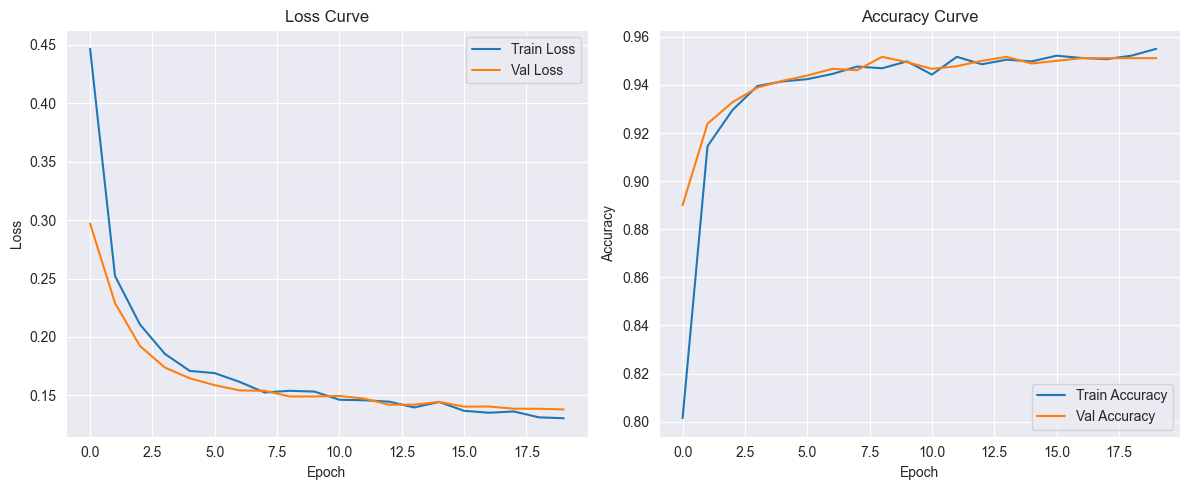


Final Test Evaluation (MLP):
Accuracy: 0.9545
F1 Score (macro): 0.9545
F1 Score (weighted): 0.9545

Classification Report:
              precision    recall  f1-score   support

           0     0.9545    0.9545    0.9545        22
           1     0.9545    0.9545    0.9545        22

    accuracy                         0.9545        44
   macro avg     0.9545    0.9545    0.9545        44
weighted avg     0.9545    0.9545    0.9545        44

Confusion Matrix:
[[21  1]
 [ 1 21]]


In [11]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """
    Run one training epoch.

    Returns:
        Tuple[float, float]: Average loss, accuracy.
    """
    model.train()
    total_loss, correct, total = 0, 0, 0

    for xb, yb in tqdm(loader, desc="Training", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    return total_loss / len(loader), correct / total


def evaluate(model, loader, criterion, device):
    """
    Evaluate model on validation/test set.

    Returns:
        Tuple[float, float, float, List[int], List[int]]:
        average loss, accuracy, macro F1, true labels, predicted labels.
    """
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item()

            preds = logits.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    f1 = f1_score(all_labels, all_preds, average='macro')
    return total_loss / len(loader), correct / total, f1, all_labels, all_preds


def run_training_pipeline_mlp(train_x, train_y, val_x, val_y, test_x, test_y):
    """
    Full training and evaluation pipeline for MLP classification.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, val_loader, test_loader = prepare_dataloaders(train_x, train_y, val_x, val_y, test_x, test_y)

    model = MLPClassifier(input_dim=train_x.shape[1], hidden_dims=[64]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    train_losses, val_losses = [], []
    train_accs, val_accs, val_f1s = [], [], []
    best_val_f1 = 0

    for epoch in range(20):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)

        print(f"\nEpoch {epoch + 1} Summary:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), "./save/best_mlp_model.pt")

    plot_training_curves(train_losses, val_losses, train_accs, val_accs)

    # Final evaluation
    model.load_state_dict(torch.load("./save/best_mlp_model.pt"))
    _, test_acc, test_f1, test_labels, test_preds = evaluate(model, test_loader, criterion, device)

    print("\nFinal Test Evaluation (MLP):")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"F1 Score (macro): {test_f1:.4f}")
    print(f"F1 Score (weighted): {f1_score(test_labels, test_preds, average='weighted'):.4f}")
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(test_labels, test_preds))


run_training_pipeline_mlp(train_x, train_y, val_x, val_y, test_x, test_y)

## Autoencoder-based Classifier


Epoch 1 Summary:
Train Acc: 0.8876, Train Loss: 0.4420
Val Acc: 0.9283, Val F1 (macro): 0.9281, Val Loss: 0.2728



Epoch 2 Summary:
Train Acc: 0.9369, Train Loss: 0.2650
Val Acc: 0.9378, Val F1 (macro): 0.9377, Val Loss: 0.1897



Epoch 3 Summary:
Train Acc: 0.9429, Train Loss: 0.2253
Val Acc: 0.9433, Val F1 (macro): 0.9433, Val Loss: 0.1647



Epoch 4 Summary:
Train Acc: 0.9417, Train Loss: 0.2024
Val Acc: 0.9417, Val F1 (macro): 0.9417, Val Loss: 0.1544



Epoch 5 Summary:
Train Acc: 0.9469, Train Loss: 0.1935
Val Acc: 0.9439, Val F1 (macro): 0.9439, Val Loss: 0.1502



Epoch 6 Summary:
Train Acc: 0.9481, Train Loss: 0.1897
Val Acc: 0.9489, Val F1 (macro): 0.9489, Val Loss: 0.1469



Epoch 7 Summary:
Train Acc: 0.9455, Train Loss: 0.1830
Val Acc: 0.9489, Val F1 (macro): 0.9488, Val Loss: 0.1386



Epoch 8 Summary:
Train Acc: 0.9476, Train Loss: 0.1801
Val Acc: 0.9522, Val F1 (macro): 0.9522, Val Loss: 0.1377



Epoch 9 Summary:
Train Acc: 0.9517, Train Loss: 0.1644
Val Acc: 0.9506, Val F1 (macro): 0.9505, Val Loss: 0.1330



Epoch 10 Summary:
Train Acc: 0.9529, Train Loss: 0.1671
Val Acc: 0.9467, Val F1 (macro): 0.9466, Val Loss: 0.1302



Epoch 11 Summary:
Train Acc: 0.9531, Train Loss: 0.1635
Val Acc: 0.9500, Val F1 (macro): 0.9499, Val Loss: 0.1286



Epoch 12 Summary:
Train Acc: 0.9531, Train Loss: 0.1557
Val Acc: 0.9500, Val F1 (macro): 0.9499, Val Loss: 0.1292



Epoch 13 Summary:
Train Acc: 0.9500, Train Loss: 0.1614
Val Acc: 0.9483, Val F1 (macro): 0.9483, Val Loss: 0.1269



Epoch 14 Summary:
Train Acc: 0.9505, Train Loss: 0.1593
Val Acc: 0.9517, Val F1 (macro): 0.9516, Val Loss: 0.1272



Epoch 15 Summary:
Train Acc: 0.9574, Train Loss: 0.1515
Val Acc: 0.9483, Val F1 (macro): 0.9483, Val Loss: 0.1255



Epoch 16 Summary:
Train Acc: 0.9512, Train Loss: 0.1495
Val Acc: 0.9472, Val F1 (macro): 0.9472, Val Loss: 0.1271



Epoch 17 Summary:
Train Acc: 0.9540, Train Loss: 0.1482
Val Acc: 0.9500, Val F1 (macro): 0.9500, Val Loss: 0.1255



Epoch 18 Summary:
Train Acc: 0.9524, Train Loss: 0.1506
Val Acc: 0.9483, Val F1 (macro): 0.9483, Val Loss: 0.1242



Epoch 19 Summary:
Train Acc: 0.9581, Train Loss: 0.1506
Val Acc: 0.9511, Val F1 (macro): 0.9511, Val Loss: 0.1237



Epoch 20 Summary:
Train Acc: 0.9550, Train Loss: 0.1485
Val Acc: 0.9517, Val F1 (macro): 0.9516, Val Loss: 0.1246



Epoch 21 Summary:
Train Acc: 0.9536, Train Loss: 0.1489
Val Acc: 0.9478, Val F1 (macro): 0.9478, Val Loss: 0.1268



Epoch 22 Summary:
Train Acc: 0.9579, Train Loss: 0.1453
Val Acc: 0.9500, Val F1 (macro): 0.9500, Val Loss: 0.1236



Epoch 23 Summary:
Train Acc: 0.9533, Train Loss: 0.1494
Val Acc: 0.9500, Val F1 (macro): 0.9500, Val Loss: 0.1235



Epoch 24 Summary:
Train Acc: 0.9524, Train Loss: 0.1486
Val Acc: 0.9517, Val F1 (macro): 0.9516, Val Loss: 0.1239



Epoch 25 Summary:
Train Acc: 0.9531, Train Loss: 0.1504
Val Acc: 0.9500, Val F1 (macro): 0.9500, Val Loss: 0.1252



Epoch 26 Summary:
Train Acc: 0.9564, Train Loss: 0.1482
Val Acc: 0.9522, Val F1 (macro): 0.9522, Val Loss: 0.1238



Epoch 27 Summary:
Train Acc: 0.9564, Train Loss: 0.1429
Val Acc: 0.9517, Val F1 (macro): 0.9516, Val Loss: 0.1262



Epoch 28 Summary:
Train Acc: 0.9569, Train Loss: 0.1422
Val Acc: 0.9506, Val F1 (macro): 0.9505, Val Loss: 0.1238



Epoch 29 Summary:
Train Acc: 0.9536, Train Loss: 0.1468
Val Acc: 0.9517, Val F1 (macro): 0.9516, Val Loss: 0.1243



Epoch 30 Summary:
Train Acc: 0.9545, Train Loss: 0.1451
Val Acc: 0.9517, Val F1 (macro): 0.9516, Val Loss: 0.1270



Epoch 31 Summary:
Train Acc: 0.9560, Train Loss: 0.1497
Val Acc: 0.9511, Val F1 (macro): 0.9511, Val Loss: 0.1227



Epoch 32 Summary:
Train Acc: 0.9600, Train Loss: 0.1358
Val Acc: 0.9506, Val F1 (macro): 0.9505, Val Loss: 0.1234



Epoch 33 Summary:
Train Acc: 0.9557, Train Loss: 0.1473
Val Acc: 0.9506, Val F1 (macro): 0.9505, Val Loss: 0.1241



Epoch 34 Summary:
Train Acc: 0.9545, Train Loss: 0.1490
Val Acc: 0.9522, Val F1 (macro): 0.9522, Val Loss: 0.1241



Epoch 35 Summary:
Train Acc: 0.9548, Train Loss: 0.1456
Val Acc: 0.9500, Val F1 (macro): 0.9500, Val Loss: 0.1252



Epoch 36 Summary:
Train Acc: 0.9581, Train Loss: 0.1429
Val Acc: 0.9528, Val F1 (macro): 0.9527, Val Loss: 0.1236



Epoch 37 Summary:
Train Acc: 0.9548, Train Loss: 0.1462
Val Acc: 0.9511, Val F1 (macro): 0.9511, Val Loss: 0.1236



Epoch 38 Summary:
Train Acc: 0.9564, Train Loss: 0.1467
Val Acc: 0.9517, Val F1 (macro): 0.9516, Val Loss: 0.1228



Epoch 39 Summary:
Train Acc: 0.9579, Train Loss: 0.1401
Val Acc: 0.9517, Val F1 (macro): 0.9516, Val Loss: 0.1230



Epoch 40 Summary:
Train Acc: 0.9545, Train Loss: 0.1448
Val Acc: 0.9506, Val F1 (macro): 0.9505, Val Loss: 0.1235



Epoch 41 Summary:
Train Acc: 0.9562, Train Loss: 0.1436
Val Acc: 0.9528, Val F1 (macro): 0.9527, Val Loss: 0.1226



Epoch 42 Summary:
Train Acc: 0.9531, Train Loss: 0.1465
Val Acc: 0.9517, Val F1 (macro): 0.9516, Val Loss: 0.1233



Epoch 43 Summary:
Train Acc: 0.9583, Train Loss: 0.1427
Val Acc: 0.9511, Val F1 (macro): 0.9511, Val Loss: 0.1226



Epoch 44 Summary:
Train Acc: 0.9590, Train Loss: 0.1425
Val Acc: 0.9506, Val F1 (macro): 0.9505, Val Loss: 0.1236



Epoch 45 Summary:
Train Acc: 0.9579, Train Loss: 0.1455
Val Acc: 0.9444, Val F1 (macro): 0.9444, Val Loss: 0.1275



Epoch 46 Summary:
Train Acc: 0.9538, Train Loss: 0.1477
Val Acc: 0.9494, Val F1 (macro): 0.9494, Val Loss: 0.1240



Epoch 47 Summary:
Train Acc: 0.9560, Train Loss: 0.1452
Val Acc: 0.9506, Val F1 (macro): 0.9505, Val Loss: 0.1220



Epoch 48 Summary:
Train Acc: 0.9555, Train Loss: 0.1465
Val Acc: 0.9517, Val F1 (macro): 0.9516, Val Loss: 0.1220



Epoch 49 Summary:
Train Acc: 0.9550, Train Loss: 0.1402
Val Acc: 0.9511, Val F1 (macro): 0.9511, Val Loss: 0.1236



Epoch 50 Summary:
Train Acc: 0.9562, Train Loss: 0.1481
Val Acc: 0.9500, Val F1 (macro): 0.9500, Val Loss: 0.1252


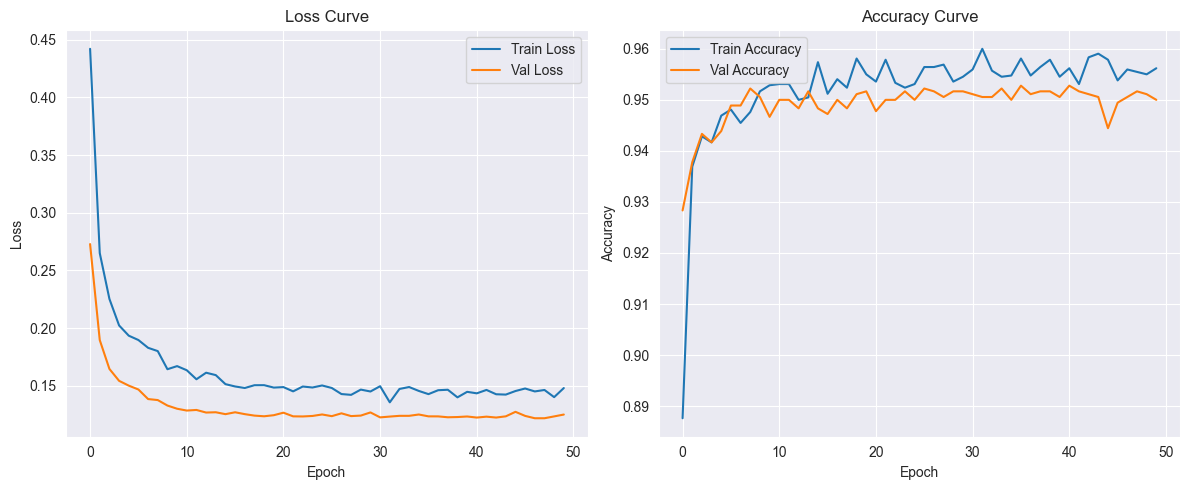


Final Test Evaluation (AE):
Accuracy: 0.9545
F1 Score (macro): 0.9545
F1 Score (weighted): 0.9545

Per-Class Classification Report:
              precision    recall  f1-score   support

           0     0.9545    0.9545    0.9545        22
           1     0.9545    0.9545    0.9545        22

    accuracy                         0.9545        44
   macro avg     0.9545    0.9545    0.9545        44
weighted avg     0.9545    0.9545    0.9545        44

Confusion Matrix:
[[21  1]
 [ 1 21]]


In [13]:
def run_training_pipeline_ae(train_x, train_y, val_x, val_y, test_x, test_y):
    """
    Full training and evaluation pipeline for MLP classification.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, val_loader, test_loader = prepare_dataloaders(train_x, train_y, val_x, val_y, test_x, test_y)

    model = AutoencoderClassifier(train_x.shape[1], dropout_rate=0.2).to(device)
    criterion_recon = nn.MSELoss()
    criterion_cls = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    best_val_f1 = 0
    for epoch in range(50):
        model.train()
        total_loss = 0
        total_recon_loss = 0
        total_cls_loss = 0
        correct = 0
        total = 0
        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch + 1}/50", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            recon, logits = model(xb)
            recon_loss = criterion_recon(recon, xb)
            cls_loss = criterion_cls(logits, yb)
            loss = 0.3 * recon_loss + 0.7 * cls_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_cls_loss += cls_loss.item()
            preds = logits.argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

        train_acc = correct / total

        # Validation loop
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                recon, logits = model(xb)
                recon_loss = criterion_recon(recon, xb)
                cls_loss = criterion_cls(logits, yb)
                loss = 0.3 * recon_loss + 0.7 * cls_loss

                val_loss += loss.item()
                preds = logits.argmax(1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(yb.cpu().numpy())
                val_correct += (preds == yb).sum().item()
                val_total += yb.size(0)

        val_acc = val_correct / val_total
        val_f1 = f1_score(val_labels, val_preds, average='macro')
        scheduler.step(val_f1)

        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), "./save/best_ae_model.pt")

        # Log for plotting
        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)

        print(f"\nEpoch {epoch + 1} Summary:")
        print(f"Train Acc: {train_acc:.4f}, Train Loss: {train_losses[-1]:.4f}")
        print(f"Val Acc: {val_acc:.4f}, Val F1 (macro): {val_f1:.4f}, Val Loss: {val_losses[-1]:.4f}")

    plot_training_curves(train_losses, val_losses, train_accs, val_accs)

    # Final evaluation
    model.load_state_dict(torch.load("./save/best_ae_model.pt"))
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            _, logits = model(xb)
            preds = logits.argmax(1).cpu().numpy()
            test_preds.extend(preds)
            test_labels.extend(yb.numpy())

    print("\nFinal Test Evaluation (AE):")
    print(f"Accuracy: {accuracy_score(test_labels, test_preds):.4f}")
    print(f"F1 Score (macro): {f1_score(test_labels, test_preds, average='macro'):.4f}")
    print(f"F1 Score (weighted): {f1_score(test_labels, test_preds, average='weighted'):.4f}")
    print("\nPer-Class Classification Report:")
    print(classification_report(test_labels, test_preds, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(test_labels, test_preds))
    torch.save(model.state_dict(), "./save/final_ae_model.pth")


run_training_pipeline_ae(train_x, train_y, val_x, val_y, test_x, test_y)